In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_parquet('train.parquet')

In [3]:
data.head()

,CompanyKey,ProfitLoss,AccountLocal,AccSide,AccountLocalCorr,Виды деятельности,Прочие доходы и расходы,Номенклатурные группы,Статьи затрат,Статьи ДДС,Amount,TargetKey,TargetName
0,BNV,0,01,Dt,08,,,,,,395599.24,24,Прочие Активы
1,BNV,0,08,Cr,01,,,,,,-395599.24,24,Прочие Активы
2,BNV,0,08,Dt,60,,,,,,395599.24,24,Прочие Активы
3,BNV,0,10,Cr,20,,,Основная номенклатурная группа,Списание материалов,,-12868.81,24,Прочие Активы
4,BNV,0,10,Cr,26,,,,почтовые расходы,,-81507.85,24,Прочие Активы


In [4]:
data.isnull().sum()

CompanyKey                    0
ProfitLoss                    0
AccountLocal                  0
AccSide                       0
AccountLocalCorr              0
Виды деятельности             0
Прочие доходы и расходы       0
Номенклатурные группы         0
Статьи затрат                 0
Статьи ДДС                    0
Amount                        0
TargetKey                  2510
TargetName                 2510
dtype: int64

In [5]:
data.CompanyKey.dtype=='category'


True

In [6]:
 data.AccountLocal =data.AccountLocal.astype(float)

In [7]:
data.AccountLocalCorr = data.AccountLocalCorr.astype(float)

In [8]:
for col in data.columns:
    if (data[col].dtype!=str) & (data[col].dtype!=float):
        data[col] = data[col].astype(str)

In [9]:
data.dtypes

CompanyKey                  object
ProfitLoss                  object
AccountLocal               float64
AccSide                     object
AccountLocalCorr           float64
Виды деятельности           object
Прочие доходы и расходы     object
Номенклатурные группы       object
Статьи затрат               object
Статьи ДДС                  object
Amount                     float64
TargetKey                   object
TargetName                  object
dtype: object

In [10]:
data['Виды деятельности'].unique()

array(['', 'Услуги', 'УСН', 'Оптовая торговля', 'Сертификация',
       'Дохід операційної діяльності (від реалізації товарів, робіт, послуг)',
       'Услуги таможенного агента', 'услуга по предоставлению гарантии',
       'услуга по предоставлению ЭПИ', 'Услуги СВХ', 'Услуги СОП',
       'Услуги таможенного склада', 'Транспортно-экспедиционные услуги',
       'Таможенные услуги', 'Прочие доходы',
       'Позитивне значення курсових різниць'], dtype=object)

In [11]:
str_col = [col  for col in data.columns if data[col].dtypes=='object']

In [12]:
str_data = data.loc[:, str_col]

In [13]:
str_data.head()

,CompanyKey,ProfitLoss,AccSide,Виды деятельности,Прочие доходы и расходы,Номенклатурные группы,Статьи затрат,Статьи ДДС,TargetKey,TargetName
0,BNV,0,Dt,,,,,,24,Прочие Активы
1,BNV,0,Cr,,,,,,24,Прочие Активы
2,BNV,0,Dt,,,,,,24,Прочие Активы
3,BNV,0,Cr,,,Основная номенклатурная группа,Списание материалов,,24,Прочие Активы
4,BNV,0,Cr,,,,почтовые расходы,,24,Прочие Активы


# Now i will transform str data to number
I wana convert all str data using one-hor-encoding, i will use tree models, may be this format data help make model better

In [14]:
data.CompanyKey.value_counts()

MLK    2102
VES    1172
MSS    1024
MPI     924
BNV     301
VIM     301
VMT     178
Name: CompanyKey, dtype: int64

In [15]:
data = pd.concat([data, pd.get_dummies(data.CompanyKey, prefix="Company_key")], axis=1)

In [16]:
data.drop('CompanyKey', axis=1, inplace=True)

In [17]:
data.ProfitLoss = data.ProfitLoss.astype(int)

In [18]:
AccSide_dict = {j:i for i, j in enumerate(data.AccSide.unique())}

In [19]:
data.AccSide=data.AccSide.map(AccSide_dict)

In [20]:
data.loc[data['Виды деятельности']=='' ,'Виды деятельности']='None'

In [21]:
data['Виды деятельности'].value_counts()

None                                                                    4559
Транспортно-экспедиционные услуги                                        469
Оптовая торговля                                                         231
Услуги таможенного агента                                                220
Таможенные услуги                                                        183
Прочие доходы                                                            138
Сертификация                                                             114
Услуги                                                                    30
услуга по предоставлению гарантии                                         10
услуга по предоставлению ЭПИ                                              10
Услуги СВХ                                                                10
Услуги СОП                                                                10
Услуги таможенного склада                                                 10

In [22]:
prom = pd.get_dummies(data['Виды деятельности'], prefix='WotkingType')

In [23]:
data = pd.concat([data, prom], axis=1)

In [24]:
data.drop('Виды деятельности', axis=1, inplace=True)

In [25]:
agr_col = ['Прочие доходы и расходы','Номенклатурные группы','Статьи затрат','Статьи ДДС']

In [26]:
for col in agr_col:
    data.loc[data[col]=='', col]='None'
    prom = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, prom], axis=1)
    data.drop(col, axis=1, inplace=True)

In [27]:
data

,ProfitLoss,AccountLocal,AccSide,AccountLocalCorr,Amount,TargetKey,TargetName,Company_key_BNV,Company_key_MLK,Company_key_MPI,...,Статьи ДДС_Эквивалент после продажи валюты,Статьи ДДС_выплата дивидендов,Статьи ДДС_доход по займу,Статьи ДДС_покупка валюты,Статьи ДДС_поступления от покупателей,Статьи ДДС_проценты полученные,Статьи ДДС_расчеты по претензиям,Статьи ДДС_спонсорская помощь,Статьи ДДС_таможенное оформление,Статьи ДДС_штраф по АП
0,0,1.0,0,8.0,395599.24,24,Прочие Активы,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,8.0,1,1.0,-395599.24,24,Прочие Активы,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,8.0,0,60.0,395599.24,24,Прочие Активы,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,10.0,1,20.0,-12868.81,24,Прочие Активы,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,10.0,1,26.0,-81507.85,24,Прочие Активы,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,0,91.0,0,99.0,1853.61,nan,None,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5998,0,91.0,0,99.0,5125.71,nan,None,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5999,1,732.0,1,311.0,-1822.43,nan,None,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6000,0,91.0,0,99.0,13.33,nan,None,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
data.loc[data.TargetKey.isnull(), :]

,ProfitLoss,AccountLocal,AccSide,AccountLocalCorr,Amount,TargetKey,TargetName,Company_key_BNV,Company_key_MLK,Company_key_MPI,...,Статьи ДДС_Эквивалент после продажи валюты,Статьи ДДС_выплата дивидендов,Статьи ДДС_доход по займу,Статьи ДДС_покупка валюты,Статьи ДДС_поступления от покупателей,Статьи ДДС_проценты полученные,Статьи ДДС_расчеты по претензиям,Статьи ДДС_спонсорская помощь,Статьи ДДС_таможенное оформление,Статьи ДДС_штраф по АП


In [29]:
train_data = data.loc[data.TargetKey!='nan', :]

In [30]:
for_target_dict = train_data.loc[:, ['TargetKey','TargetName']].drop_duplicates()
target_dict = {i:j for i, j in zip(for_target_dict.TargetKey, for_target_dict.TargetName)}

In [31]:
train_data.drop('TargetName', axis=1, inplace=True)

/home/uladzimir/anaconda3/envs/biv_arr/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
train_data.TargetKey= train_data.TargetKey.astype(int)

/home/uladzimir/anaconda3/envs/biv_arr/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [33]:
X = train_data.drop('TargetKey', axis=1)
y = train_data.TargetKey

In [65]:
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)

In [38]:
dec_tree = DecisionTreeClassifier() 
extra_tree = ExtraTreeClassifier()

In [40]:
dec_tree.fit(X_train, y_train)
extra_tree.fit(X_train, y_train)

ExtraTreeClassifier()

In [60]:
pred_dec = dec_tree.predict(X_test)
pred_extra = extra_tree.predict(X_test)

In [62]:
print(f"dec_tree {accuracy_score(y_test, pred_dec)} \n extra_tree {accuracy_score(y_test, pred_extra)}")

dec_tree 0.9064885496183206 
 extra_tree 0.6040076335877863


In [68]:
num_test = np.linspace(0.3, 1, 10)

In [90]:
train_sizes, train_scores, validation_scores  = learning_curve(
        DecisionTreeClassifier(),
        X,
        y,
        cv=10,
        train_sizes = num_test,
        scoring = 'accuracy',
        n_jobs=-1,
    )

/home/uladzimir/anaconda3/envs/biv_arr/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


In [93]:
train_scores_mean = train_scores.mean(axis = 1)
validation_scores_mean = validation_scores.mean(axis =1)

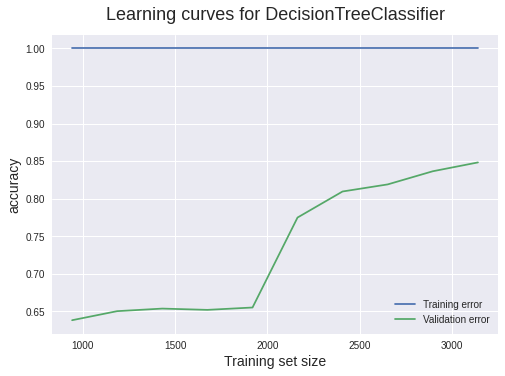

In [94]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('accuracy', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for DecisionTreeClassifier', fontsize = 18, y = 1.03)
plt.legend()

AttributeError: 'Series' object has no attribute 'sorted'